<a href="https://colab.research.google.com/github/SoniaVG/Analysis-of-data/blob/main/ProblemaClasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
# Librerías principales
import numpy as np
import pandas as pd

# para procesamiento
from sklearn import preprocessing as pp
from sklearn.preprocessing import StandardScaler
# Librerías para graficas
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px
color = sns.color_palette()
%matplotlib inline

In [141]:
# Librerías modelación de los datos (entrenamiento, evaluación de resultados, reducción de dimensión, transformación)
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
import statsmodels as sm

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [142]:
df = pd.read_excel('/content/default of credit card clients.xls',header=0,skiprows=[0])
df.head(2)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


## <font color="darkred">Análisis de los datos usando gráficas  </font>

In [ ]:
# Distribución de algunas variables categoricas y numericas
def descripcion(variables, df, Color, tipo_variable):
  fig, axes = plt.subplots(1, len(variables))
  for var, pos in zip(variables, np.arange(len(variables))):
    if tipo_variable=="den":
      b = sns.kdeplot(x  = var, data=df, color =Color,ax=axes[pos])
      b.set_xlabel(var,fontsize=8)
      b.set_ylabel('Density',fontsize=8)
      b.tick_params(labelsize=8)
    else:
      b = sns.countplot(x  = var, data=df, color =Color,saturation = 0.75,ax=axes[pos])
      b.set_xlabel(var,fontsize=8)
      b.set_ylabel('count',fontsize=8)
      b.tick_params(labelsize=8)
  plt.tight_layout()
  plt.show()

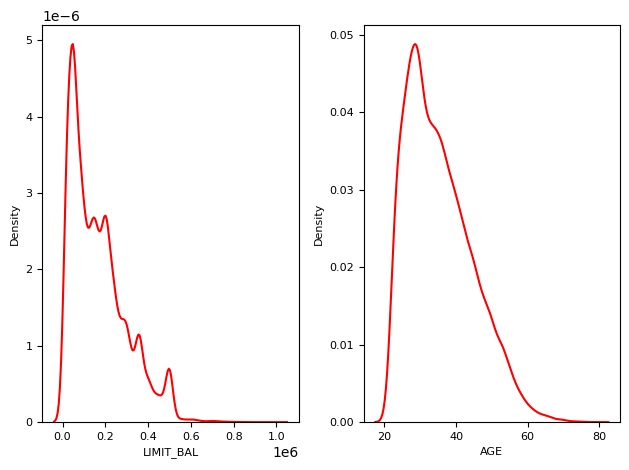

GRAFICA IMCUMPLIERON


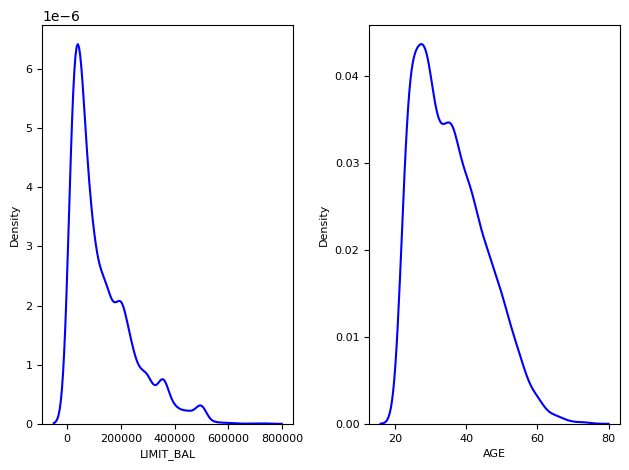

GRAFICA NO IMCUMPLIERON


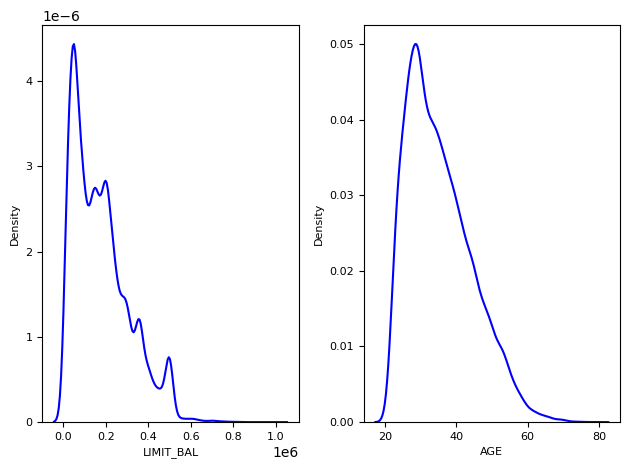

In [ ]:
# grafica de tada la data
descripcion(['LIMIT_BAL','AGE'], df, "red",'den')
print('GRAFICA IMCUMPLIERON')
descripcion(['LIMIT_BAL','AGE'], df[df['default payment next month']==1], "blue",'den')
print('GRAFICA NO IMCUMPLIERON')
descripcion(['LIMIT_BAL','AGE'], df[df['default payment next month']==0], "blue",'den')


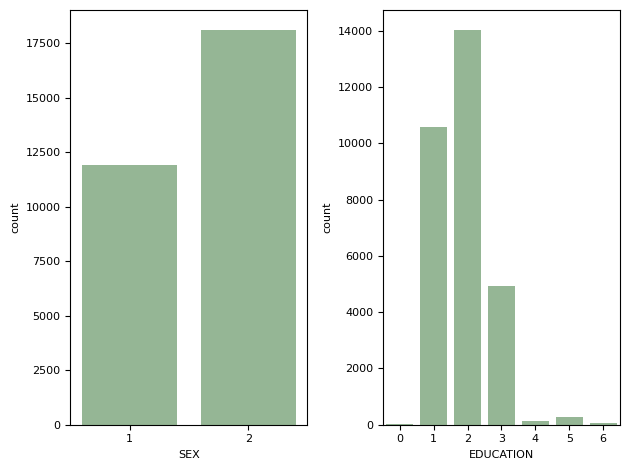

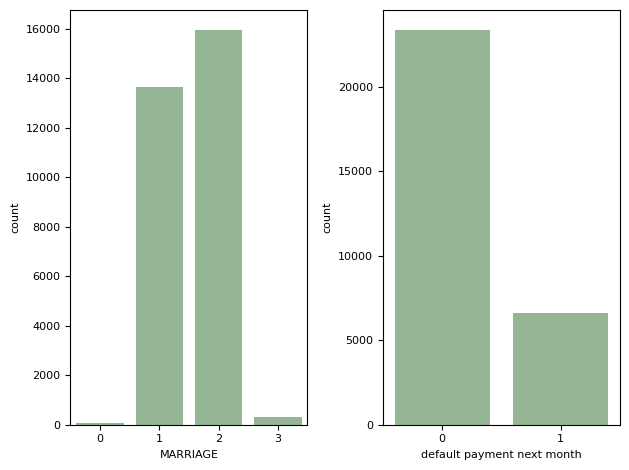

In [ ]:
descripcion(['SEX','EDUCATION'], df, "darkseagreen",'cat')
descripcion(['MARRIAGE','default payment next month'], df,"darkseagreen",'cat')

In [ ]:
# Distribucion por Conteos
def conteos(variables, var_agrupado):
  agrupado =  df[variables].groupby(var_agrupado,as_index=False).value_counts()
  agrupado = agrupado.rename(columns={'count':'conteo'})
  agrupado['porc%'] = agrupado.conteo/agrupado.conteo.sum()*100
  return agrupado

In [ ]:
# Proporciones de las variable objetivo: 'default payment next month'
# Verificamos que las clases son desbalanceadas
conteos(['default payment next month'], ['default payment next month'])

,default payment next month,conteo,porc%
0,0,23364,77.88
1,1,6636,22.12


In [ ]:
# Sólo para ver si las proporciones de los segmentos con estas 2 variables se mantienen ¨similares¨
#.................................................................................................
conteos(['default payment next month','SEX'], ['default payment next month','SEX'])

,default payment next month,SEX,conteo,porc%
0,0,1,9015,30.050000
1,0,2,14349,47.830000
2,1,1,2873,9.576667
3,1,2,3763,12.543333


In [ ]:
conteos(['default payment next month','MARRIAGE'], ['default payment next month','MARRIAGE'])

,default payment next month,MARRIAGE,conteo,porc%
0,0,0,49,0.163333
1,0,1,10453,34.843333
2,0,2,12623,42.076667
3,0,3,239,0.796667
4,1,0,5,0.016667
5,1,1,3206,10.686667
6,1,2,3341,11.136667
7,1,3,84,0.280000


##<font color="darkred"> RESUMEN PARTE DESCRIPTIVA DE LOS DATOS:

1.   La varible que se usara para clasificar es desvalanceada ($78%$ vs $22%$)
2.   Las distribuciones o segementación por las variables genero, edad, y otros por lo general son similares



## <font color="darkred">Análisis de correlación de los datos  </font>
* En este paso, antes deconstruir modelos predictivos se sugiere verificar si hay variables que esten altamente correlacionadas, ya que muchos modelos predictivos estan basado en la no existencia de correlación/ multicolinealidad de los datos.

In [ ]:
mat_corr = df.corr()

Como hay 25 columnas, y las correlaciones se calculan por pares de variables, entonces existen $$\binom{25}{2} = \frac{25\times 24}{2!}=300$$ combinaciones, y por tanto 300 valores de correlaciones (una por cada par de variables).

In [ ]:
umbrales = [0.65,0.7, 0.75,0.8,0.9]
lista = []
for th in umbrales:
  val = (np.where(mat_corr>th, 1,0).sum()-25)/2 # menos la diaganal y entre dos porque la matriz es simetrica
  print(f"{int(val)} pares de variables con alta correlación: (>|{th}|)")

23 pares de variables con alta correlación: (>|0.65|)
20 pares de variables con alta correlación: (>|0.7|)
19 pares de variables con alta correlación: (>|0.75|)
17 pares de variables con alta correlación: (>|0.8|)
6 pares de variables con alta correlación: (>|0.9|)


 **Observación:**<font color="darkred"> De la información anterior se puede ver que si existe alta correlación entre las variables, por lo cual se suguiere transformar los datos originales a otros, o recidir la dimensión de los datos bajo una transformación y obtener nuevos valores sin alta correlación (este caso, se usara PCA para transformar los datos).

#<font color="darkred"> Análisis de componentes principales PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

X = df.iloc[:,0:24]
Y = df[['default payment next month']]

# esto es sólo para ver los pesos que se generan para las variables y componentes
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(X)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

print('Mientras más alto los pesos, las componentes recogen mayor información de las variables asociadas a estos pesos\n')

pd.DataFrame(
    data    = modelo_pca.components_,
    columns = X.columns,
    index   = ['pca'+str(val+1) for val in np.arange(X.shape[1])]
).head(3)
# estos sólo son los pesos de la transformación

Mientras más alto los pesos, las componentes recogen mayor información de las variables asociadas a estos pesos



,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
pca1,0.006372,0.068576,-0.021631,0.019241,-0.005641,0.014263,0.161008,0.194059,0.200144,0.206984,...,0.349799,0.353921,0.351766,0.344528,0.094252,0.078701,0.086448,0.077811,0.075365,0.069961
pca2,-0.022930,-0.316218,-0.030720,0.091153,0.043466,-0.066703,0.298194,0.334765,0.343876,0.344477,...,-0.146067,-0.145400,-0.143575,-0.141687,-0.149009,-0.139780,-0.151674,-0.141306,-0.137040,-0.129274
pca3,0.058979,-0.017085,-0.023184,0.323544,-0.460945,0.469427,0.017224,-0.016221,-0.059577,-0.085566,...,0.081332,0.068916,0.054226,0.045224,-0.275986,-0.295265,-0.272316,-0.232779,-0.191624,-0.205694


Porcentaje de varianza explicada por cada una de las componentes
[0.2726381  0.17083159 0.06470214 0.0614085  0.04365895 0.04106621
 0.0395654  0.03780221 0.03696921 0.03629678 0.03249152 0.03053234
 0.02844441 0.02378875 0.0218289 ] 

Varianza de las primeras 15 componentes: 0.9420250135647269


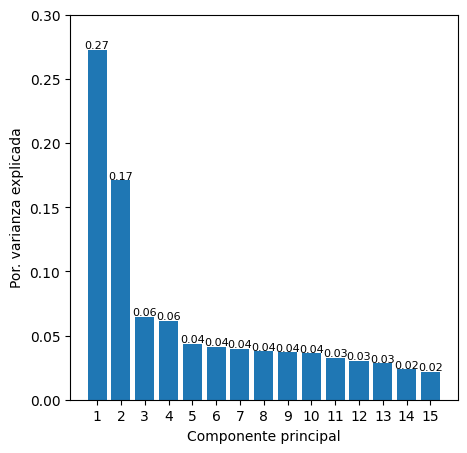

In [ ]:
# Ver las componentes que tienen mayor % de varianza explicada, sólo voy a ver las de 15 componentes
print('Porcentaje de varianza explicada por cada una de las componentes')
print(modelo_pca.explained_variance_ratio_[0:15],'\n')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
ax.bar(
    x      = np.arange(modelo_pca.n_components_)[0:15]+ 1,
    height = modelo_pca.explained_variance_ratio_[0:15]
)

for x, y in zip(np.arange(len(X.columns)-9) + 1, modelo_pca.explained_variance_ratio_[0:15]):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,1),
        ha='center', size=8
    )

ax.set_xticks(np.arange(modelo_pca.n_components_)[0:15]+ 1)
ax.set_ylim(0,0.3)
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

print('Varianza de las primeras 15 componentes:', modelo_pca.explained_variance_ratio_[0:15].sum())

In [ ]:
# Para reducir la dimensionalidad de los datos, me voy a quedar con nuevas observaciones, que son las proyecciones en el espacio definido por las componentes.
# proyecciones = producto_punto(modelo_pca.components_, datos).T
proyecciones = pca_pipe.transform(X=X)
proyecciones = pd.DataFrame(
    proyecciones,
    columns = ['pca'+str(val+1) for val in np.arange(X.shape[1])],
    index   = X.index
)

# Me quedo con las 15 componentes
proyecciones =  proyecciones[['pca'+str(val+1) for val in np.arange(X.shape[1]-9)]]
proyecciones.head(3)

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15
0,-1.899099,0.944774,0.378828,-0.642703,-0.188105,-1.783138,0.926400,0.494659,0.218778,0.253505,0.157143,-0.260298,3.225044,-1.058131,0.372657
1,-0.776113,2.148283,-1.199002,-0.546323,-0.196156,-1.637975,0.526471,-0.167535,0.188465,0.207973,0.317870,-0.152842,-0.919548,0.067392,0.327544
2,-0.858630,1.111385,-0.517439,-0.515650,-0.317224,-1.583381,0.806793,0.031117,0.010443,0.212800,0.302197,-0.058665,-0.313828,0.507558,-0.282632


In [ ]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF, index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1)
    nombres_col = tempDF.columns
    plt.figure(figsize=(4,4))
    sns.scatterplot(x=nombres_col[0], y=nombres_col[1], hue=nombres_col[2], \
               data=tempDF)
    ax = plt.gca()

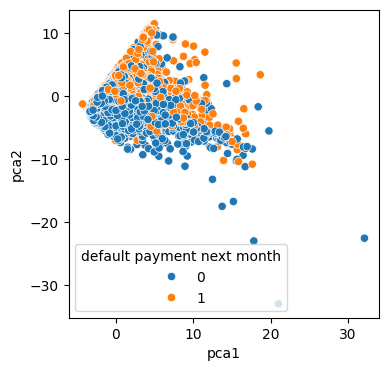

In [ ]:
scatterPlot(proyecciones[['pca1','pca2']], df[['default payment next month']], "PCA")

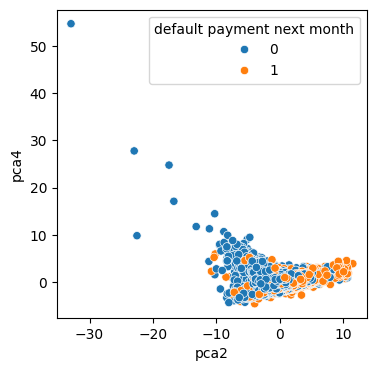

In [ ]:
scatterPlot(proyecciones[['pca2','pca4']], df[['default payment next month']], "PCA")

Separación de las proyecciones usando GaussianRandomProjection


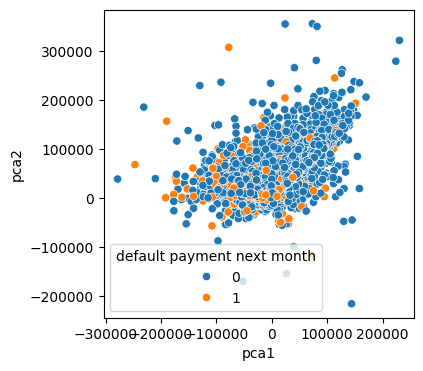

In [ ]:
# VEr una proyección Gaussiana, para ver si podríamos hacer una mejor separación entre las clases
#----------------------------------
from sklearn.random_projection import GaussianRandomProjection

n_components = 15
eps = 0.7
random_state = 2025

GRP = GaussianRandomProjection(n_components=n_components, eps=eps,random_state=random_state)

X_train_GRP = GRP.fit_transform(X)
X_train_GRP = pd.DataFrame(data=X_train_GRP, index=X.index,
    columns = ['pca'+str(val+1) for val in np.arange(15)],
                           )

scatterPlot(X_train_GRP[['pca1','pca2']], Y, "Gaussian Random Projection")
print("Separación de las proyecciones usando GaussianRandomProjection")

#<font color="darkred">**Modelos**
**Observación 1**: <font color="darkred"> Considerando que los datos originales presentan alta correlación en algunas variables, usamos PCA para transformas los datos, considerando 15 componentes principales, que dada su naturaleza de las componentes, estas ya no presentan correlación entre ellas.

**Observación 2:** <font color="darkred">La variable que usamos para predecir cada uno de los modelos supervisados, son desvalanceados, por lo cual, hay que considerar que es complejo entrenar un modelo que tenga por completo buena capacidad predictiva.

* Algunas sugerencias son, hacer una comparativa entre estos casos:
    * A. Entrenar modelos con ese desbalance en los datos.
    * B. Entrenar modelos con datos balanceados usando submuestreo.
    * C. Entrenar modelos con datos balanceados usando sobremuestreo.

# <font color="darkred"> Caso A. Entrenamiento con los datos desbalanceados.

* Es ya usando los datos transformados con PCA

In [ ]:
# Porcentajes de datos sobre el conjunto de prueba y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(
    proyecciones, Y, test_size=0.2, random_state=42, stratify=Y
)

In [ ]:
# tamaños de los datos divididos
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (24000, 15)
Shape of y_train:  (24000, 1)
Shape of X_test:  (6000, 15)
Shape of y_test:  (6000, 1)


## <font color="darkred"> REGRESIÓN LOGÍSTICA

In [ ]:

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=16)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from sklearn import metrics
def mat_confusion(cnf_matrix):
  class_names=[0,1] # name  of classes
  fig, ax = plt.subplots(figsize=(5, 4))
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
# create heatmap
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True ,fmt='g', cmap="Blues")
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Valor real')
  plt.xlabel('Valor predicho')

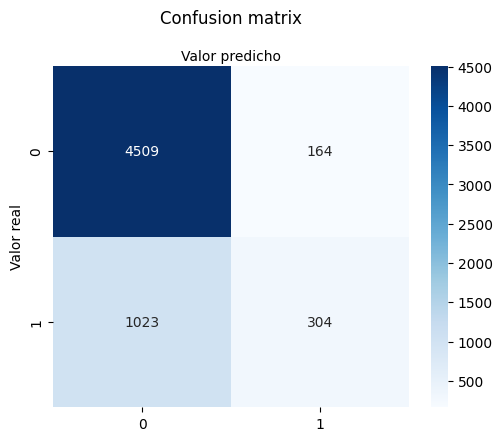

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
mat_confusion(cnf_matrix)

EL modelo tiene un $80%$ de presición (porcentaje en que clasifica correctamente), sin embargo para este caso donde los datos son desvalanceados no se consideran como una buena medida.


Por otro lado, también es necesario preguntarse qué es más  valioso para nosotros:
* Clasificar a una persona como no pagará, cuando realmente si lo hará: aquí hay 1,023  casos
* o clasificar a una persona como: pagará,  cuando realment no lo hará: aquí son 164 casos

In [ ]:
# Algunas otras métricas que nos ayudarán a tomar la mejor desición
from sklearn.metrics import classification_report
target_names = ['0','1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88      4673
           1       0.65      0.23      0.34      1327

    accuracy                           0.80      6000
   macro avg       0.73      0.60      0.61      6000
weighted avg       0.78      0.80      0.76      6000



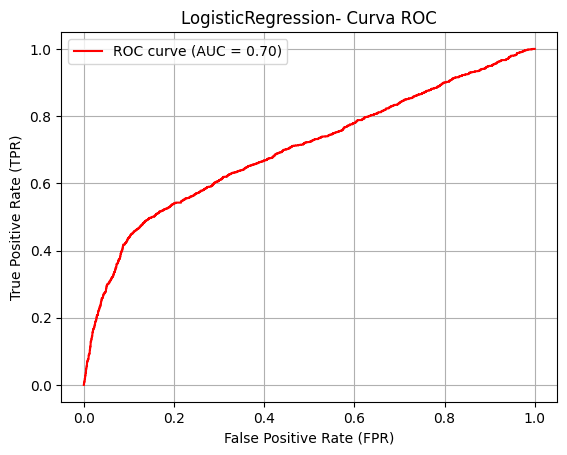

In [ ]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]

def grafica_ROC(model,y_test, y_pred_proba_model):
  fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_model)
  auc = metrics.roc_auc_score(y_test, y_pred_proba_model)
  plt.plot(fpr,tpr, label=f'ROC curve (AUC = {float(auc):.2f})', color='red')
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.title(model+'- Curva ROC')
  plt.legend()
  plt.grid()
  plt.show()

# curva roc para el modelo de regresión logístico
grafica_ROC('LogisticRegression',y_test, y_pred_proba)

## <font color="darkred"> XGBOOST

In [ ]:
#!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 12.5 MB/s eta 0:00:00


In [ ]:
def objective_xgb(trial):
    # Definir conjunto de los  hiperparámetros a optimizar
    param_dist_xgb = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'lambda': trial.suggest_float('lambda', 0, 10),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [4])
    }
    xgb = XGBClassifier(**param_dist_xgb, eval_metric='logloss', random_state=42)

    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    f1_scores = cross_val_score(xgb, X_train, y_train, scoring='f1', cv=stratified_kfold)

    return np.mean(f1_scores)

In [ ]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=10)

[I 2025-06-27 15:08:07,912] A new study created in memory with name: no-name-f3049645-212a-466f-a904-c3636d2b622d
[I 2025-06-27 15:08:12,821] Trial 0 finished with value: 0.4952445033086841 and parameters: {'n_estimators': 100, 'learning_rate': 0.2730286424291146, 'max_depth': 6, 'subsample': 0.6930483306564656, 'colsample_bytree': 0.7130473460073604, 'gamma': 0.8142035582581125, 'lambda': 5.689344539308648, 'scale_pos_weight': 4}. Best is trial 0 with value: 0.4952445033086841.
[I 2025-06-27 15:08:16,120] Trial 1 finished with value: 0.4947758616506327 and parameters: {'n_estimators': 400, 'learning_rate': 0.4736305115511099, 'max_depth': 9, 'subsample': 0.9857651509652055, 'colsample_bytree': 0.760388597804996, 'gamma': 4.572305365712972, 'lambda': 7.745521742281587, 'scale_pos_weight': 4}. Best is trial 0 with value: 0.4952445033086841.
[I 2025-06-27 15:08:28,588] Trial 2 finished with value: 0.4984964344958918 and parameters: {'n_estimators': 500, 'learning_rate': 0.157088895985703

In [ ]:
print("Mejores hiperparámetros encontrados: ", study_xgb.best_params)

Mejores hiperparámetros encontrados:  {'n_estimators': 200, 'learning_rate': 0.0986591273438807, 'max_depth': 9, 'subsample': 0.9208161236292296, 'colsample_bytree': 0.9001469175054116, 'gamma': 4.848123561997958, 'lambda': 8.785019316046112, 'scale_pos_weight': 4}


In [ ]:
# Nos quedamos con el mejor modelo para evaluarlo
best_params_xgb = study_xgb.best_params
xgb_final_model = XGBClassifier(**best_params_xgb)
xgb_final_model.fit(X_train, y_train)

y_pred_xgb = xgb_final_model.predict(X_test)
y_pred_xgb_proba = xgb_final_model.predict_proba(X_test)[:, 1]
# y_pred_ajusted_xgb = np.where(y_pred_xgb_proba >= 0.453, 1, 0)

In [ ]:
print(classification_report(y_test, y_pred_xgb, target_names=target_names))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      4673
           1       0.46      0.60      0.52      1327

    accuracy                           0.76      6000
   macro avg       0.67      0.70      0.68      6000
weighted avg       0.79      0.76      0.77      6000



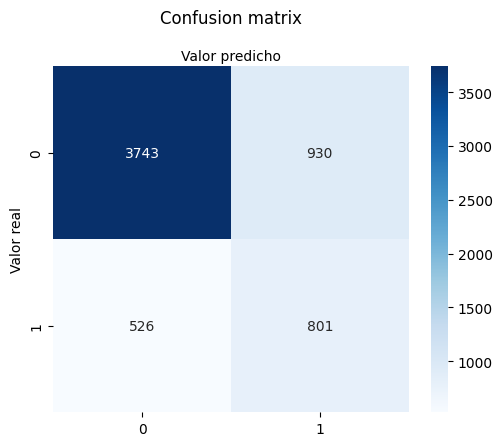

In [ ]:
cnf_matrix_xgb =confusion_matrix(y_test, y_pred_xgb)
mat_confusion(cnf_matrix_xgb)

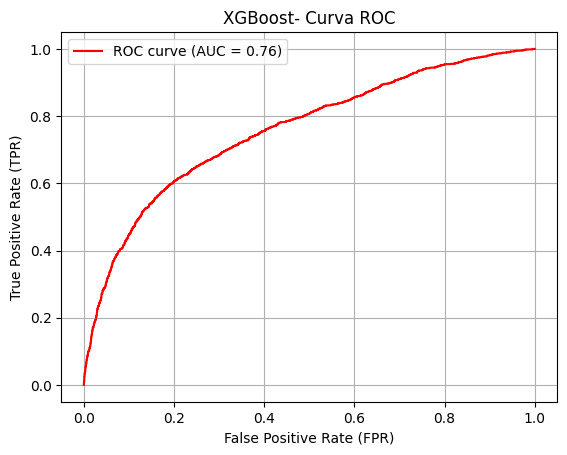

In [ ]:
grafica_ROC('XGBoost',y_test, y_pred_xgb_proba)

# <font color="darkred"> RandomForest

In [ ]:
def objective_rf(trial):
    # Hiperparámetros para optimizar
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=50)
    max_depth = trial.suggest_categorical('max_depth', [5, 7, 10, 13, 15])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10, step=1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, step=2)
    class_weight = trial.suggest_categorical('class_weight', ['balanced'])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight=class_weight,
        bootstrap=bootstrap,
        random_state=42
    )

    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = cross_val_score(rf, X_train, y_train, scoring='f1', cv=stratified_kfold)
    return np.mean(f1_scores)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=3)

[I 2025-06-27 19:27:14,897] A new study created in memory with name: no-name-3fc7fbbe-6ae2-4569-82af-e0aecdd78fec
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A colu

In [ ]:
print("Mejores hiperparámetros encontrados:", study_rf.best_params)

Mejores hiperparámetros encontrados: {'n_estimators': 50, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 8, 'class_weight': 'balanced', 'bootstrap': True}


In [ ]:
# Entrenamiento con el mejor modelo

best_params_rf = study_rf.best_params
rf_final_model = RandomForestClassifier(**best_params_rf)

rf_final_model.fit(X_train, y_train)

y_pred_rf = rf_final_model.predict(X_test)

y_pred_rf_proba = rf_final_model.predict_proba(X_test)[:, 1]
# y_pred_ajusted_rf = np.where(y_pred_rf_proba >= 0.5, 1, 0)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
print(classification_report(y_test, y_pred_rf, target_names=target_names))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      4673
           1       0.52      0.56      0.54      1327

    accuracy                           0.79      6000
   macro avg       0.70      0.71      0.70      6000
weighted avg       0.80      0.79      0.79      6000



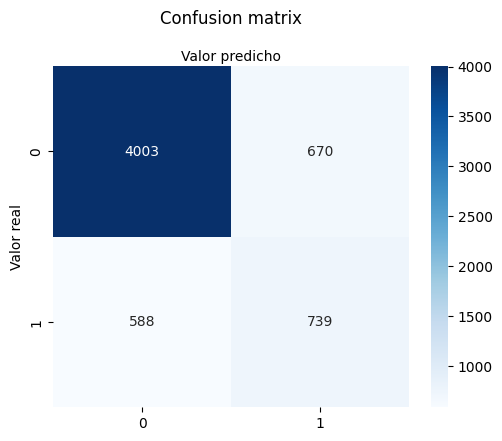

In [ ]:
cnf_matrix_rf =confusion_matrix(y_test, y_pred_rf)
mat_confusion(cnf_matrix_rf)

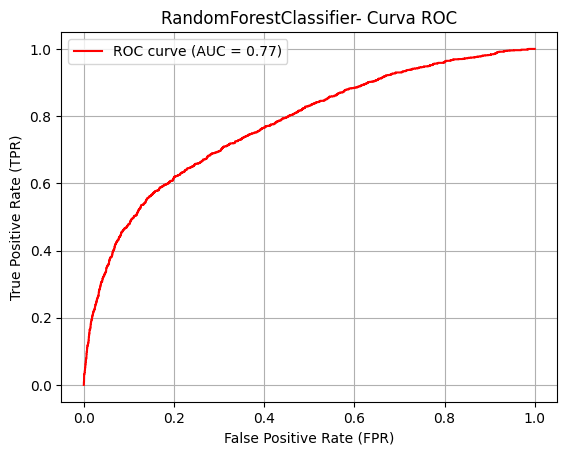

In [ ]:
grafica_ROC('RandomForestClassifier',y_test, y_pred_rf_proba)

# <font color="darkred"> Este paso es sólo validación
 del porque predecir sobre datos con alta correlación no es buena idea, ya que en este caso la capacidad predictiva del modelo puede ser nada bueno.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y)

In [ ]:
# tamaños de los datos divididos
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (24000, 24)
Shape of y_train:  (24000, 1)
Shape of X_test:  (6000, 24)
Shape of y_test:  (6000, 1)


In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=16)
logreg.fit(X_train, y_train)
y_pred_orig = logreg.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


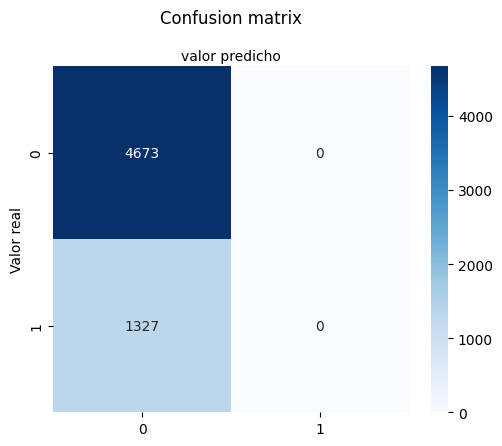

In [ ]:
cnf_matrix_orig = metrics.confusion_matrix(y_test, y_pred_orig)
mat_confusion(cnf_matrix_orig)

# <font color="darkblue"> **PROBLEMA DE REGRESIÓN:**
<font color="darkblue"> Predicción de la variable PAY_AMT4

In [ ]:
df.head(2)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


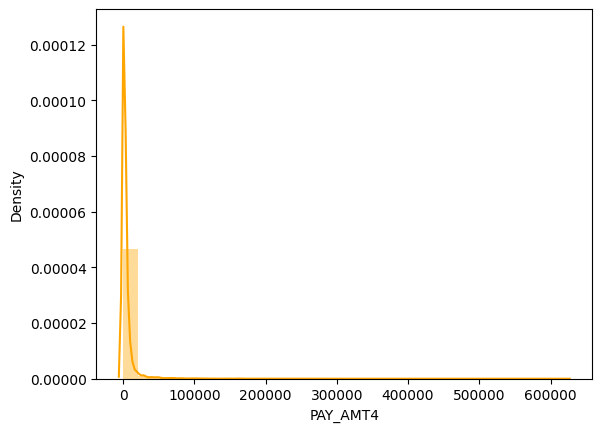

In [ ]:
sns.distplot(df['PAY_AMT4'], bins=30, color="Orange")
plt.show()

In [144]:
XX = df[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT5', 'PAY_AMT6']]
YY = df[['PAY_AMT4']]

# <font color="darkblue"> Modelo lineal

In [150]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

In [151]:
X_train, X_test, y_train, y_test = train_test_split(XX, YY,test_size = 0.30, random_state=0)

In [152]:
modelo = make_pipeline(StandardScaler(with_mean=True), LinearRegression())
modelo.fit(X = X_train, y = y_train)
prediccion = modelo.predict(X_test)
# Metricas
print('r^2: %0.3f'  % modelo.score(X_test,y_test))
print('RMSE: %0.3f'  % np.sqrt(mean_squared_error(prediccion,y_test)))

r^2: 0.309
RMSE: 13116.901


In [224]:
import xgboost as xgb

xgb_r = xgb.XGBRegressor(objective ='reg:linear',  n_estimators =8, max_depth=8, learning_rate=0.49, seed = 123)
xgb_r.fit(X_train, y_train)
pred_xgb = xgb_r.predict(X_test)

print('r^2: %0.3f'  % xgb_r.score(X_test,y_test))
print('RMSE: %0.3f'  % np.sqrt(mean_squared_error(pred_xgb,y_test)))

r^2: 0.702
RMSE: 8617.754


In [229]:
from xgboost import XGBRegressor
def objective(trial):
    param = {
        "objective":"reg:linear",
        'lambda': trial.suggest_loguniform('lambda', 0.1, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1.0, 5),
        'eta': trial.suggest_categorical('eta', [0.3, 0.4, 0.5, 1.0]),
        'gamma': trial.suggest_categorical('gamma', [0.1 ,0.2, 4, 5]),
        'n_estimators': trial.suggest_int('n_estimators', 1, 10),
        'max_depth': trial.suggest_categorical('max_depth', [1, 4, 6, 8])
      }
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    mae = np.sqrt(mean_squared_error(predict, y_test))
    return mae

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=8)


[I 2025-06-27 22:40:23,847] A new study created in memory with name: no-name-8de631c6-ee8c-4f75-8fc6-eb190d00be35
[I 2025-06-27 22:40:24,176] Trial 0 finished with value: 15583.129339128262 and parameters: {'lambda': 0.443458009582683, 'alpha': 1.1267526155437408, 'eta': 0.3, 'gamma': 4, 'n_estimators': 2, 'max_depth': 1}. Best is trial 0 with value: 15583.129339128262.
[I 2025-06-27 22:40:24,757] Trial 1 finished with value: 9393.359782314314 and parameters: {'lambda': 0.15797372737888427, 'alpha': 1.1470005799039096, 'eta': 0.5, 'gamma': 0.1, 'n_estimators': 3, 'max_depth': 8}. Best is trial 1 with value: 9393.359782314314.
[I 2025-06-27 22:40:25,173] Trial 2 finished with value: 8475.333149794173 and parameters: {'lambda': 0.9472448294737595, 'alpha': 3.4837541591590897, 'eta': 0.4, 'gamma': 0.1, 'n_estimators': 8, 'max_depth': 6}. Best is trial 2 with value: 8475.333149794173.
[I 2025-06-27 22:40:25,424] Trial 3 finished with value: 10289.525936601744 and parameters: {'lambda': 0.7

In [230]:
print("Mejores hiperparámetros encontrados:", study.best_params)


Mejores hiperparámetros encontrados: {'lambda': 0.9472448294737595, 'alpha': 3.4837541591590897, 'eta': 0.4, 'gamma': 0.1, 'n_estimators': 8, 'max_depth': 6}


In [232]:
best_params = study.best_params
final_model = XGBRegressor(**best_params)

final_model.fit(X_train, y_train)

y_pred_xgb = final_model.predict(X_test)
np.sqrt(mean_squared_error(y_pred_xgb, y_test))

np.float64(8475.333149794173)